In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports for LSTM
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    LSTM_AVAILABLE = True
    print("TensorFlow available - LSTM model will be included")
except ImportError:
    LSTM_AVAILABLE = False
    print("TensorFlow not available - LSTM model will be skipped")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


TensorFlow available - LSTM model will be included
Libraries imported successfully!


In [10]:
#  Data Loading and Initial Exploration
print(" LOADING APPLE (AAPL) STOCK DATA FROM YAHOO FINANCE")


# Download AAPL stock data from 2020-2025
data = yf.download("AAPL", start="2015-01-01", end="2025-12-31")
print("Data downloaded successfully!")
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())

print("\nDataset Info:")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Total trading days: {len(data)}")
print(f"Columns: {list(data.columns)}")

print("\nBasic Statistics:")
print(data.describe())

# Check for missing values
print(f"\nMissing values: {data.isnull().sum().sum()}")

 LOADING APPLE (AAPL) STOCK DATA FROM YAHOO FINANCE


C:\Users\akhil\AppData\Local\Temp\ipykernel_9700\3064064144.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!
Dataset shape: (2693, 5)

First 5 rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261049  24.729272  23.821673  24.718176  212818400
2015-01-05  23.577570  24.110146  23.391169  24.030260  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910435  24.010292  23.677432  23.788385  160423600
2015-01-08  24.829126  24.886823  24.121244  24.238856  237458000

Dataset Info:
Date range: 2015-01-02 to 2025-09-17
Total trading days: 2693
Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]

Basic Statistics:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   2693.000000  2693.000000  2693.000000  2693.000000


 EXPLORATORY DATA ANALYSIS


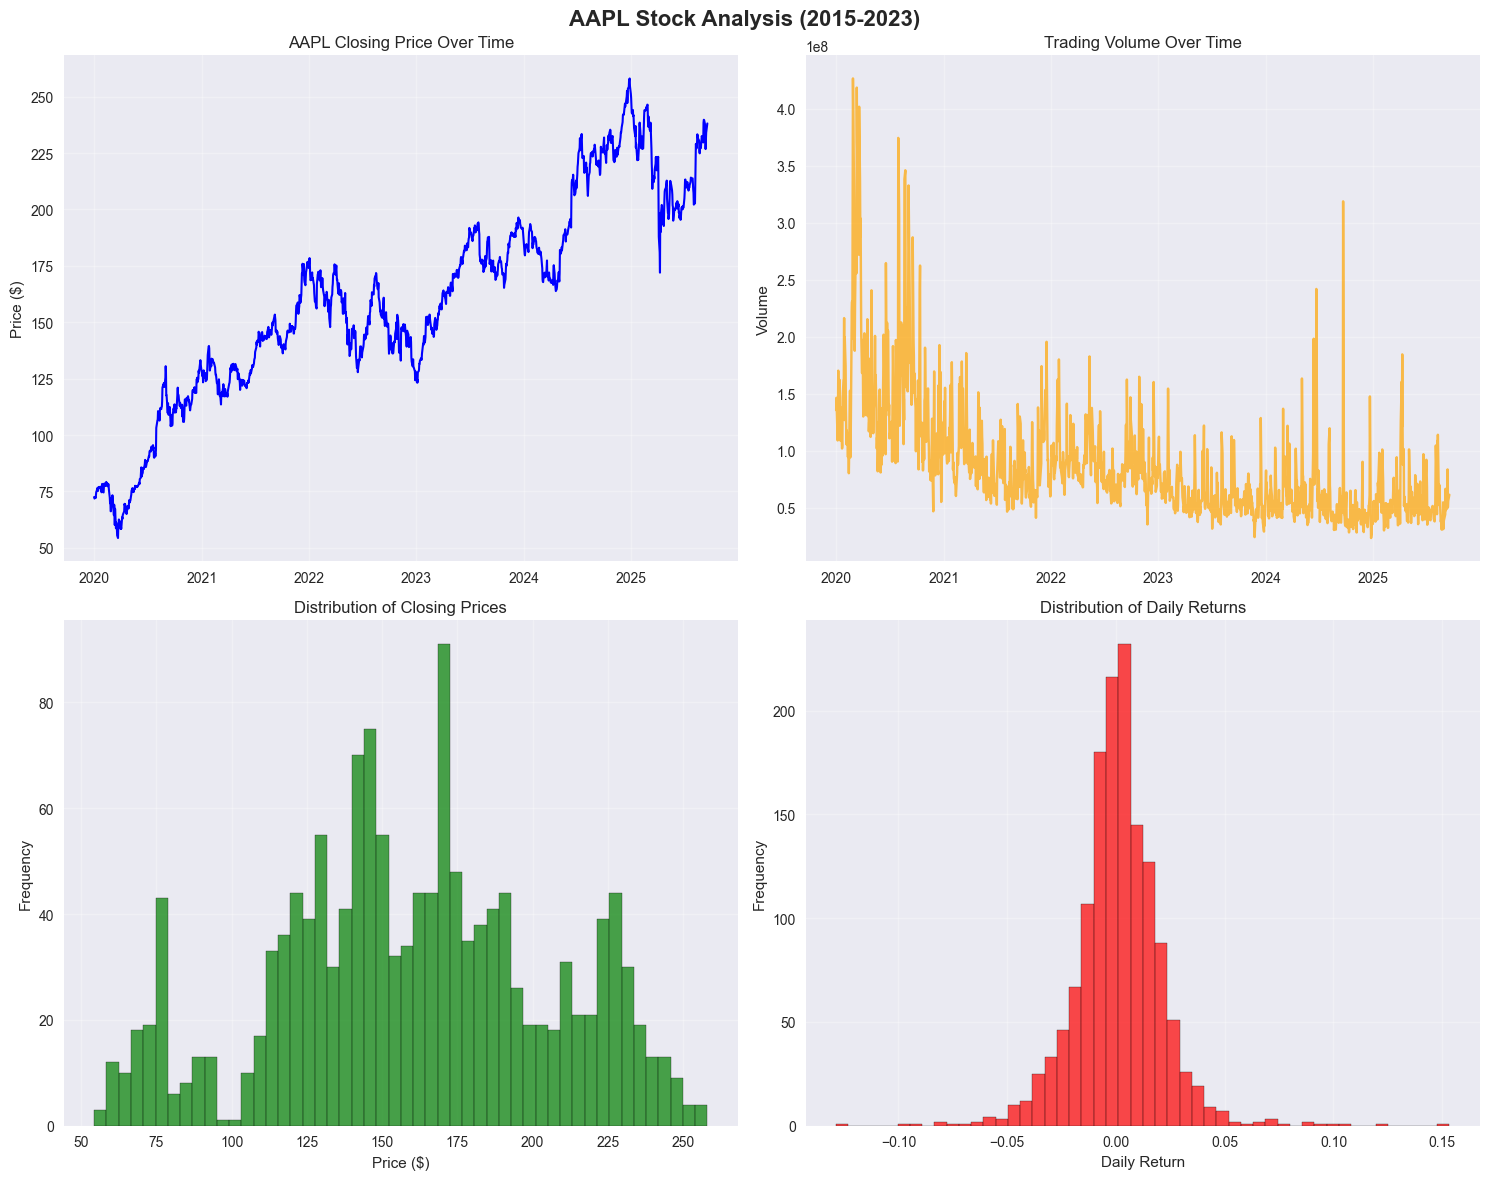

Average closing price: $159.83
Highest price: $259.18
Lowest price: $51.47
Average daily return: 0.0010 (0.10%)
Volatility (std of returns): 0.0204 (2.04%)


In [4]:
#  Data Visualization and Exploratory Analysis
print("\n EXPLORATORY DATA ANALYSIS")


# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('AAPL Stock Analysis (2015-2023)', fontsize=16, fontweight='bold')

# 1. Stock Price Over Time
axes[0, 0].plot(data.index, data['Close'], color='blue', linewidth=1.5)
axes[0, 0].set_title('AAPL Closing Price Over Time')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Volume Analysis
axes[0, 1].plot(data.index, data['Volume'], color='orange', alpha=0.7)
axes[0, 1].set_title('Trading Volume Over Time')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True, alpha=0.3)

# 3. Price Distribution
axes[1, 0].hist(data['Close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Closing Prices')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Daily Returns
daily_returns = data['Close'].pct_change().dropna()
axes[1, 1].hist(daily_returns, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Daily Returns')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average closing price: ${float(data['Close'].mean()):.2f}")
print(f"Highest price: ${float(data['High'].max()):.2f}")
print(f"Lowest price: ${float(data['Low'].min()):.2f}")
print(f"Average daily return: {float(daily_returns.mean()):.4f} ({float(daily_returns.mean())*100:.2f}%)")
print(f"Volatility (std of returns): {float(daily_returns.std()):.4f} ({float(daily_returns.std())*100:.2f}%)")


In [5]:
#  Feature Engineering

print("\n FEATURE ENGINEERING")


# Create a copy for feature engineering
df = data.copy()

# Clean duplicate column names (if any)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = df.columns.str.strip()
df = df.loc[:, ~df.columns.duplicated()]


# Ensure 'Close', 'High', 'Low', 'Volume' are Series (not DataFrames)
for col in ['Close', 'High', 'Low', 'Volume']:
    if isinstance(df[col], pd.DataFrame):
        df[col] = df[col].iloc[:, 0]

# Technical Indicators
def calculate_technical_indicators(df):
    # Moving Averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()

    # Ensure bb_std is Series
    if isinstance(bb_std, pd.DataFrame):
        bb_std = bb_std.iloc[:, 0]

    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    
    # Price-based features
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
    df['Price_Change'] = df['Close'].pct_change()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # Lag features
    for i in [1, 2, 3, 5]:
        df[f'Close_Lag_{i}'] = df['Close'].shift(i)
        df[f'Volume_Lag_{i}'] = df['Volume'].shift(i)
    
    return df

# Apply function
df = calculate_technical_indicators(df)

# Create target variable (next day's closing price)
df['Target'] = df['Close'].shift(-1)

# Remove rows with NaN values
df_clean = df.dropna()

print(f"Features created: {len(df_clean.columns)} columns")
print(f"Clean dataset shape: {df_clean.shape}")
print("\nFeature columns:")
for i, col in enumerate(df_clean.columns):
    print(f"{i+1:2d}. {col}")



 FEATURE ENGINEERING
Features created: 25 columns
Clean dataset shape: (1383, 25)

Feature columns:
 1. Close
 2. High
 3. Low
 4. Open
 5. Volume
 6. MA_5
 7. MA_10
 8. MA_20
 9. MA_50
10. RSI
11. BB_Middle
12. BB_Upper
13. BB_Lower
14. High_Low_Pct
15. Price_Change
16. Volume_Change
17. Close_Lag_1
18. Volume_Lag_1
19. Close_Lag_2
20. Volume_Lag_2
21. Close_Lag_3
22. Volume_Lag_3
23. Close_Lag_5
24. Volume_Lag_5
25. Target


In [6]:
#  Data Preparation for Machine Learning

print("\n PREPARING DATA FOR MACHINE LEARNING")


# Select features for modeling
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI',
    'High_Low_Pct', 'Price_Change', 'Volume_Change',
    'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5',
    'Volume_Lag_1', 'Volume_Lag_2'
]

X = df_clean[feature_columns]
y = df_clean['Target']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data (80% train, 20% test)
# For time series, we use the last 20% as test set
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train date range: {df_clean.index[0].date()} to {df_clean.index[split_index-1].date()}")
print(f"Test date range: {df_clean.index[split_index].date()} to {df_clean.index[-1].date()}")

# Scale features for LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("Data scaling completed!")


 PREPARING DATA FOR MACHINE LEARNING
Feature matrix shape: (1383, 19)
Target vector shape: (1383,)
Training set: 1106 samples
Test set: 277 samples
Train date range: 2020-03-13 to 2024-08-05
Test date range: 2024-08-06 to 2025-09-12
Data scaling completed!


In [7]:
  # Model 1 - Linear Regression


print("\n MODEL 1: LINEAR REGRESSION")
print("=" * 50)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)

# Calculate metrics
lr_train_r2 = r2_score(y_train, lr_pred_train)
lr_test_r2 = r2_score(y_test, lr_pred_test)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_pred_train))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_pred_test))
lr_train_mae = mean_absolute_error(y_train, lr_pred_train)
lr_test_mae = mean_absolute_error(y_test, lr_pred_test)

print("Linear Regression Results:")
print(f"Training R²: {lr_train_r2:.4f}")
print(f"Test R²: {lr_test_r2:.4f}")
print(f"Training RMSE: ${lr_train_rmse:.2f}")
print(f"Test RMSE: ${lr_test_rmse:.2f}")
print(f"Training MAE: ${lr_train_mae:.2f}")
print(f"Test MAE: ${lr_test_mae:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': abs(lr_model.coef_)
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


 MODEL 1: LINEAR REGRESSION
Linear Regression Results:
Training R²: 0.9939
Test R²: 0.9280
Training RMSE: $2.62
Test RMSE: $4.15
Training MAE: $1.95
Test MAE: $2.80

Top 10 Most Important Features:
          feature  importance
11   Price_Change   42.610469
3           Close    1.092987
10   High_Low_Pct    0.321549
13    Close_Lag_1    0.301983
1            High    0.249846
0            Open    0.231733
12  Volume_Change    0.193845
2             Low    0.128817
5            MA_5    0.062178
6           MA_10    0.018023


In [8]:
#  Model 2 - Random Forest Regression

print("\n MODEL 2: RANDOM FOREST REGRESSION")


# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_test_r2 = r2_score(y_test, rf_pred_test)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_train_mae = mean_absolute_error(y_train, rf_pred_train)
rf_test_mae = mean_absolute_error(y_test, rf_pred_test)

print("Random Forest Results:")
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")
print(f"Training RMSE: ${rf_train_rmse:.2f}")
print(f"Test RMSE: ${rf_test_rmse:.2f}")
print(f"Training MAE: ${rf_train_mae:.2f}")
print(f"Test MAE: ${rf_test_mae:.2f}")

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(rf_feature_importance.head(10))


 MODEL 2: RANDOM FOREST REGRESSION
Random Forest Results:
Training R²: 0.9990
Test R²: 0.5808
Training RMSE: $1.08
Test RMSE: $10.02
Training MAE: $0.80
Test MAE: $7.40

Top 10 Most Important Features (Random Forest):
        feature  importance
3         Close    0.707347
2           Low    0.080762
1          High    0.061230
8         MA_50    0.042420
0          Open    0.026198
7         MA_20    0.022198
5          MA_5    0.020347
14  Close_Lag_2    0.014303
6         MA_10    0.012022
13  Close_Lag_1    0.006457


In [9]:
#  Model 3 - LSTM Neural Network (if TensorFlow available)

if LSTM_AVAILABLE:
    print("\n MODEL 3: LSTM NEURAL NETWORK")
   
    
    # Prepare data for LSTM (sequences)
    def create_sequences(X, y, sequence_length=60):
        X_seq, y_seq = [], []
        for i in range(sequence_length, len(X)):
            X_seq.append(X[i-sequence_length:i])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)
    
    sequence_length = 60
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length)
    
    print(f"LSTM Training sequences: {X_train_seq.shape}")
    print(f"LSTM Test sequences: {X_test_seq.shape}")
    
    # Build LSTM model
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    
    print("Training LSTM model...")
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        batch_size=32,
        epochs=50,
        validation_split=0.1,
        verbose=0
    )
    
    # Make predictions
    lstm_pred_train = lstm_model.predict(X_train_seq, verbose=0)
    lstm_pred_test = lstm_model.predict(X_test_seq, verbose=0)
    
    # Inverse transform predictions
    lstm_pred_train_inv = scaler_y.inverse_transform(lstm_pred_train).flatten()
    lstm_pred_test_inv = scaler_y.inverse_transform(lstm_pred_test).flatten()
    y_train_seq_inv = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1)).flatten()
    y_test_seq_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    lstm_train_r2 = r2_score(y_train_seq_inv, lstm_pred_train_inv)
    lstm_test_r2 = r2_score(y_test_seq_inv, lstm_pred_test_inv)
    lstm_train_rmse = np.sqrt(mean_squared_error(y_train_seq_inv, lstm_pred_train_inv))
    lstm_test_rmse = np.sqrt(mean_squared_error(y_test_seq_inv, lstm_pred_test_inv))
    lstm_train_mae = mean_absolute_error(y_train_seq_inv, lstm_pred_train_inv)
    lstm_test_mae = mean_absolute_error(y_test_seq_inv, lstm_pred_test_inv)
    
    print("LSTM Results:")
    print(f"Training R²: {lstm_train_r2:.4f}")
    print(f"Test R²: {lstm_test_r2:.4f}")
    print(f"Training RMSE: ${lstm_train_rmse:.2f}")
    print(f"Test RMSE: ${lstm_test_rmse:.2f}")
    print(f"Training MAE: ${lstm_train_mae:.2f}")
    print(f"Test MAE: ${lstm_test_mae:.2f}")

else:
    print("\n🧠 MODEL 3: LSTM NEURAL NETWORK")
    print("=" * 50)
    print("LSTM model skipped - TensorFlow not available")
    print("To use LSTM, install TensorFlow: pip install tensorflow")



 MODEL 3: LSTM NEURAL NETWORK
LSTM Training sequences: (1046, 60, 19)
LSTM Test sequences: (217, 60, 19)
Training LSTM model...
LSTM Results:
Training R²: 0.9653
Test R²: 0.4196
Training RMSE: $5.34
Test RMSE: $13.08
Training MAE: $4.08
Test MAE: $11.03


In [10]:
#  Model Comparison and Results Visualization

print("\n MODEL COMPARISON")


# Create comparison dataframe
if LSTM_AVAILABLE:
    comparison_data = {
        'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
        'Test_R2': [lr_test_r2, rf_test_r2, lstm_test_r2],
        'Test_RMSE': [lr_test_rmse, rf_test_rmse, lstm_test_rmse],
        'Test_MAE': [lr_test_mae, rf_test_mae, lstm_test_mae]
    }
else:
    comparison_data = {
        'Model': ['Linear Regression', 'Random Forest'],
        'Test_R2': [lr_test_r2, rf_test_r2],
        'Test_RMSE': [lr_test_rmse, rf_test_rmse],
        'Test_MAE': [lr_test_mae, rf_test_mae]
    }

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_model_idx = comparison_df['Test_R2'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n Best Model: {best_model} (R² = {comparison_df.loc[best_model_idx, 'Test_R2']:.4f})")



 MODEL COMPARISON
Model Performance Comparison:
               Model  Test_R2  Test_RMSE  Test_MAE
0  Linear Regression   0.9280     4.1528    2.8022
1      Random Forest   0.5808    10.0215    7.3952
2               LSTM   0.4196    13.0788   11.0284

 Best Model: Linear Regression (R² = 0.9280)



 GENERATING PREDICTION GRAPHS


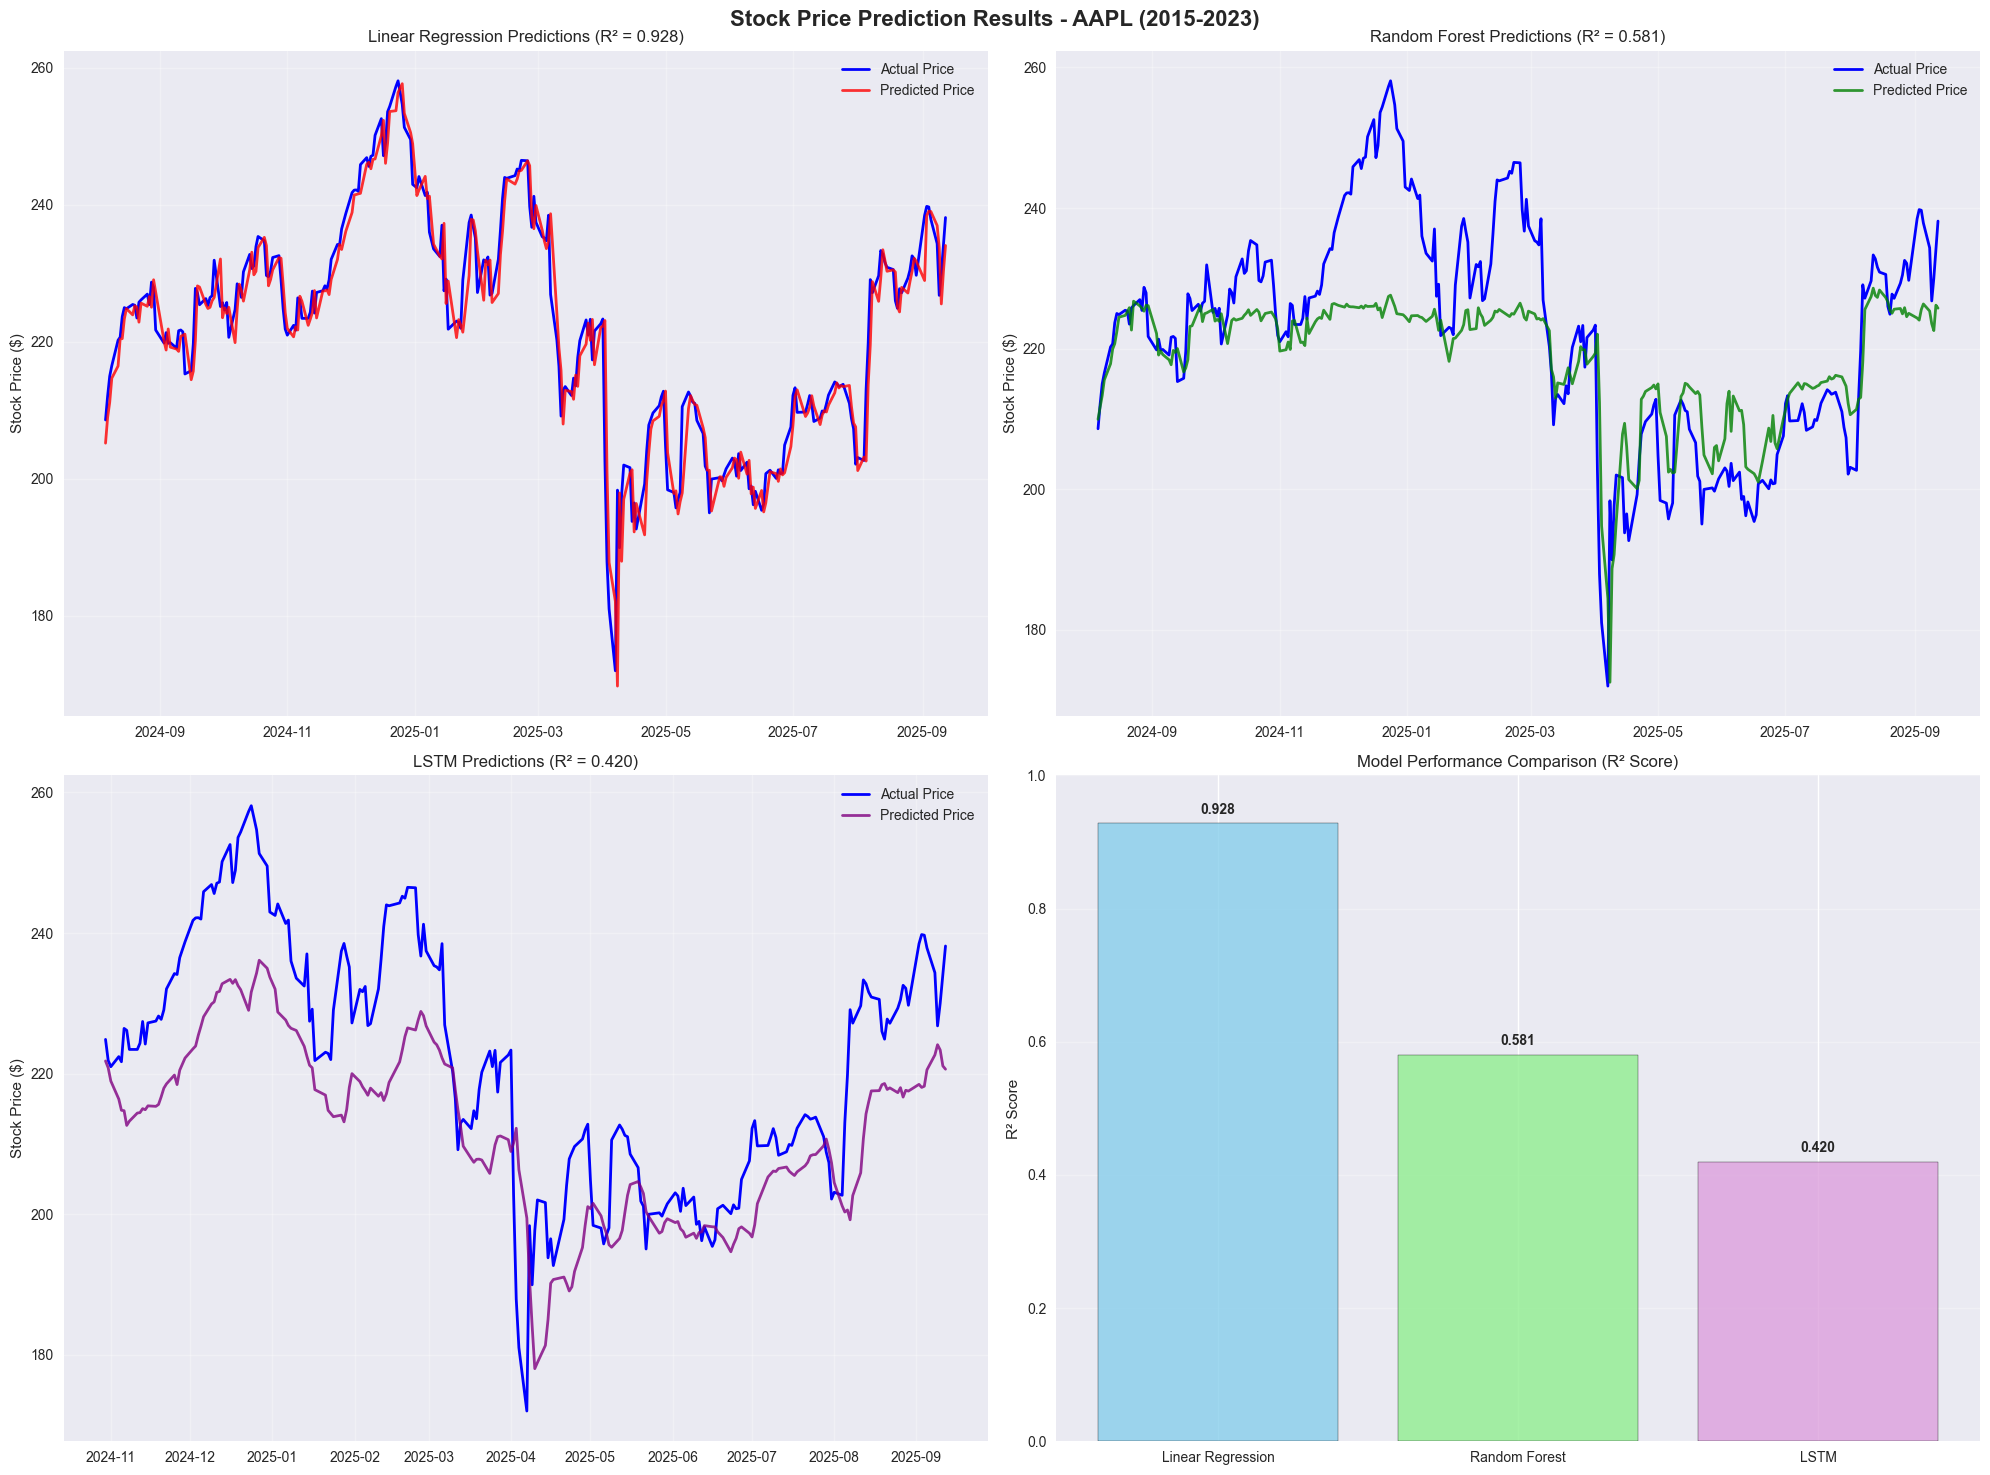

In [11]:
print("\n GENERATING PREDICTION GRAPHS")


# Create comprehensive prediction plots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Stock Price Prediction Results - AAPL (2015-2023)', fontsize=16, fontweight='bold')

# Get test dates for plotting
test_dates = df_clean.index[split_index:]

# Plot 1: Linear Regression Predictions
axes[0, 0].plot(test_dates, y_test.values, label='Actual Price', color='blue', linewidth=2)
axes[0, 0].plot(test_dates, lr_pred_test, label='Predicted Price', color='red', linewidth=2, alpha=0.8)
axes[0, 0].set_title(f'Linear Regression Predictions (R² = {lr_test_r2:.3f})')
axes[0, 0].set_ylabel('Stock Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Random Forest Predictions
axes[0, 1].plot(test_dates, y_test.values, label='Actual Price', color='blue', linewidth=2)
axes[0, 1].plot(test_dates, rf_pred_test, label='Predicted Price', color='green', linewidth=2, alpha=0.8)
axes[0, 1].set_title(f'Random Forest Predictions (R² = {rf_test_r2:.3f})')
axes[0, 1].set_ylabel('Stock Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: LSTM Predictions (if available)
if LSTM_AVAILABLE:
    lstm_test_dates = test_dates[sequence_length:]
    axes[1, 0].plot(lstm_test_dates, y_test_seq_inv, label='Actual Price', color='blue', linewidth=2)
    axes[1, 0].plot(lstm_test_dates, lstm_pred_test_inv, label='Predicted Price', color='purple', linewidth=2, alpha=0.8)
    axes[1, 0].set_title(f'LSTM Predictions (R² = {lstm_test_r2:.3f})')
    axes[1, 0].set_ylabel('Stock Price ($)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    

else:
    axes[1, 0].text(0.5, 0.5, 'LSTM Model\nNot Available\n(TensorFlow required)', 
                    ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=14)
    axes[1, 0].set_title('LSTM Predictions (Not Available)')

# Plot 4: Model Comparison Bar Chart
models = comparison_df['Model']
r2_scores = comparison_df['Test_R2']
colors = ['skyblue', 'lightgreen', 'plum'][:len(models)]

bars = axes[1, 1].bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Model Performance Comparison (R² Score)')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [12]:

print(" STOCK PRICE PREDICTION PROJECT COMPLETED!")
print(f"Dataset: Apple (AAPL) stock from 2015-2023")
print(f"Total samples: {len(df_clean)}")
print(f"Features used: {len(feature_columns)}")

print(f"\n BEST PERFORMING MODEL: {best_model}")
print(f"Best R² Score: {comparison_df.loc[best_model_idx, 'Test_R2']:.4f}")
print(f"Best RMSE: ${comparison_df.loc[best_model_idx, 'Test_RMSE']:.2f}")


 STOCK PRICE PREDICTION PROJECT COMPLETED!
Dataset: Apple (AAPL) stock from 2015-2023
Total samples: 1383
Features used: 19

 BEST PERFORMING MODEL: Linear Regression
Best R² Score: 0.9280
Best RMSE: $4.15


In [7]:
#EXTRA STEP NOT IMPORTANT

import pandas as pd

# Copy original data
df = data.copy()

# Clean duplicate column names (if any)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = df.columns.str.strip()
df = df.loc[:, ~df.columns.duplicated()]

# Ensure 'Close', 'High', 'Low', 'Volume' are Series (not DataFrames)
for col in ['Close', 'High', 'Low', 'Volume']:
    if isinstance(df[col], pd.DataFrame):
        df[col] = df[col].iloc[:, 0]

# ===============================
# 📌 Feature Engineering Function
# ===============================
def calculate_technical_indicators(df):
    # Moving Averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)

    # Price-based features
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
    df['Price_Change'] = df['Close'].pct_change()
    df['Volume_Change'] = df['Volume'].pct_change()

    # Lag features
    for i in [1, 2, 3, 5]:
        df[f'Close_Lag_{i}'] = df['Close'].shift(i)
        df[f'Volume_Lag_{i}'] = df['Volume'].shift(i)

    return df

# Apply feature engineering
df = calculate_technical_indicators(df)

# Target variable (next day's closing price)
df['Target'] = df['Close'].shift(-1)

# Drop NaN rows
df_clean = df.dropna()

print("✅ Feature Engineering Done")
print("Shape:", df_clean.shape)
print("Columns:", df_clean.columns.tolist()[:10], "...")


✅ Feature Engineering Done
Shape: (2214, 25)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI'] ...


In [8]:
print(type(df_clean))
print(df_clean.shape)
df_clean.head()


<class 'pandas.core.frame.DataFrame'>
(2214, 25)


Price,Close,High,Low,Open,Volume,MA_5,MA_10,MA_20,MA_50,RSI,...,Volume_Change,Close_Lag_1,Volume_Lag_1,Close_Lag_2,Volume_Lag_2,Close_Lag_3,Volume_Lag_3,Close_Lag_5,Volume_Lag_5,Target
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-16,27.836658,27.836658,27.373272,27.598281,143497200,27.613429,28.021346,28.451760,26.612772,32.710738,...,-0.307811,27.533678,207309200.0,27.725264,193450800.0,27.232916,275756000.0,28.324551,354114000.0,28.302273
2015-03-17,28.302273,28.364652,27.992605,28.048301,204092400,27.726158,27.969659,28.442960,26.693597,45.533422,...,0.422274,27.836658,143497200.0,27.533678,207309200.0,27.725264,193450800.0,27.738630,275426400.0,28.620853
2015-03-18,28.620853,28.774574,28.153011,28.293363,261083600,28.003745,27.968100,28.440175,26.794462,44.971680,...,0.279242,28.302273,204092400.0,27.836658,143497200.0,27.533678,207309200.0,27.232916,275756000.0,28.404747
2015-03-19,28.404747,28.794616,28.382469,28.683225,183238000,28.139642,27.992382,28.429593,26.890961,47.391262,...,-0.298164,28.620853,261083600.0,28.302273,204092400.0,27.836658,143497200.0,27.725264,193450800.0,28.048294
2015-03-20,28.048294,28.605248,27.883436,28.571832,274780400,28.242565,27.976786,28.389492,26.973718,41.765582,...,0.499582,28.404747,183238000.0,28.620853,261083600.0,28.302273,204092400.0,27.533678,207309200.0,28.340141


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib

# Features (X) and Target (y)
X = df_clean.drop(columns=['Target'])
y = df_clean['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Save model and features
joblib.dump(model, "stock_model.pkl")
joblib.dump(X.columns.tolist(), "features.pkl")

print("✅ Model trained and saved as stock_model.pkl & features.pkl")


✅ Model trained and saved as stock_model.pkl & features.pkl
